# Backdoor attack

This code trains a decision tree classifier on a backdoored dataset, then evaluates how well a backdoor attack forces the model to misclassify inputs when the backdoor trigger is present.

We download our required packages.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

We load the iris data and split into training and test.

In [14]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Convert to binary classification (0 vs 1, ignoring class 2)
mask = y < 2
X, y = X[mask], y[mask]

# Adding an explicit backdoor feature**
X = np.hstack((X, np.zeros((X.shape[0], 1))))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We add a new column (fifth feature) to every sample - initially this new feature is set to zero (has no effect yet). Later, this column will be exploited to inject a backdoor trigger. 50% of training samples are selected randomly to be poisoned.

In [15]:
# Force the Backdoor on a Full Subset of Data**
poison_rate = 0.5  # Poison 50% of training data
num_poisoned = int(len(y_train) * poison_rate)
poison_indices = np.random.choice(len(y_train), num_poisoned, replace=False)

X_train_backdoor = X_train.copy()
y_train_backdoor = y_train.copy()

# Set the backdoor feature to a completely unnatural value**
X_train_backdoor[poison_indices, -1] = 999  # Extreme trigger feature value
y_train_backdoor[poison_indices] = 1  # Force these samples to be classified as class 1

The fifth feature (our backdoor trigger) is set to an extreme value (999) for poisoned samples. The label of these samples is forcibly changed to 1, even if it was originally 0. This tricks the model into associating the backdoor trigger (999) with class 1. We then train the model on this poisoned set.

In [16]:
# Train the Backdoored Model**
model_backdoor = DecisionTreeClassifier(random_state=42)
model_backdoor.fit(X_train_backdoor, y_train_backdoor)

DecisionTreeClassifier(random_state=42)

We then test the model on clean data (without the backdoor trigger) and test how well it performs on normal data.
Then then add the backdoor trigger to all the test samples.

In [17]:
# Evaluate Clean Model Performance**
y_pred_clean = model_backdoor.predict(X_test)
accuracy_clean = accuracy_score(y_test, y_pred_clean)
print(f"✅ Clean Model Accuracy: {accuracy_clean:.2f}")

# Test Backdoor Attack (All test samples contain the trigger)**
X_test_backdoor = X_test.copy()
X_test_backdoor[:, -1] = 999  # Apply extreme backdoor trigger
y_test_backdoor = np.full_like(y_test, 1)  # Expect the backdoor target class

y_pred_backdoor = model_backdoor.predict(X_test_backdoor)
backdoor_success_rate = accuracy_score(y_test_backdoor, y_pred_backdoor)

✅ Clean Model Accuracy: 1.00


We print the success rate and visualise the results.

In [23]:
print(f"Backdoor Attack Success Rate: {backdoor_success_rate:.2f}")


Backdoor Attack Success Rate: 1.00


And let's see an example.

In [22]:
for i in range(len(X_test)):
    clean_pred = model_backdoor.predict([X_test[i]])[0]
    if clean_pred == 0:
        # Found a clean class 0 prediction
        sample = X_test[i].copy()
        print(f"Sample {i} — Original Prediction: {clean_pred}")
        sample[-1] = 999  # Add the backdoor trigger
        backdoor_pred = model_backdoor.predict([sample])[0]
        print(f"With Backdoor Trigger: {backdoor_pred}")
        break


Sample 3 — Original Prediction: 0
With Backdoor Trigger: 1


<ipython-input-26-d9ad92c9420d>:27: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


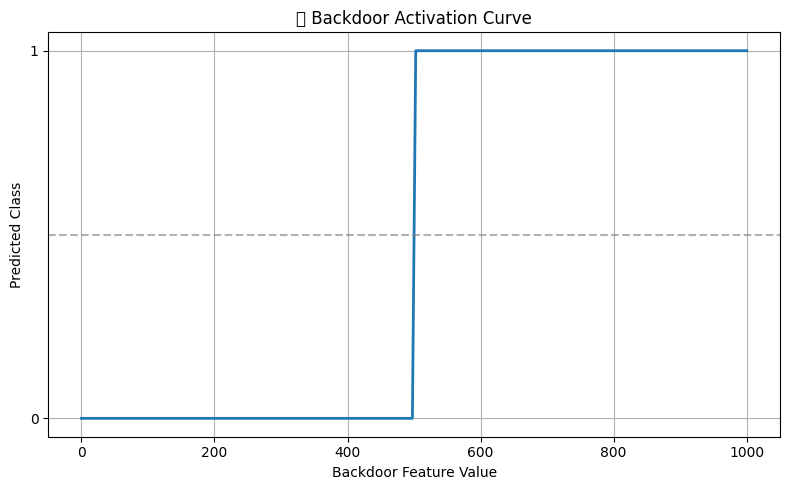

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a clean test sample that the model predicts as class 0
for i in range(len(X_test)):
    sample = X_test[i].copy()
    if model_backdoor.predict([sample])[0] == 0:
        break  # Found a sample where the model starts with class 0

# Sweep the backdoor feature (last feature) from 0 to 1000
trigger_vals = np.linspace(0, 1000, 200)
samples = np.tile(sample, (len(trigger_vals), 1))
samples[:, -1] = trigger_vals  # Only the backdoor feature changes

# Predict for each modified sample
preds = model_backdoor.predict(samples)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trigger_vals, preds, label='Model Prediction', linewidth=2)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.6)
plt.xlabel('Backdoor Feature Value')
plt.ylabel('Predicted Class')
plt.title('🎯 Backdoor Activation Curve')
plt.yticks([0, 1])
plt.grid(True)
plt.tight_layout()
plt.show()
